# COCO workflow

> Example workflow for creating a COCO-style dataset and training an object detection model with `detectron2`

In [ ]:
import rasterio as rio
import geopandas as gpd
from pathlib import Path
import rasterio.plot as rioplot
import matplotlib.pyplot as plt

In [ ]:
path_to_data = Path('workflow_examples/')
train_raster = path_to_data/'104_28_Hiidenportti_Chunk1_orto.tif'
train_shp = path_to_data/'104_28_Hiidenportti_Chunk1_orto.geojson'
test_raster = path_to_data/'104_42_Hiidenportti_Chunk5_orto.tif'
test_shp = path_to_data/'104_42_Hiidenportti_Chunk5_orto.geojson'

Example data is RGB UAV imagery from Hiidenportti, and the task is to detect and segment different deadwood types. The reference data are annotated as polygons, and target column is `layer`.

Training area looks like this.

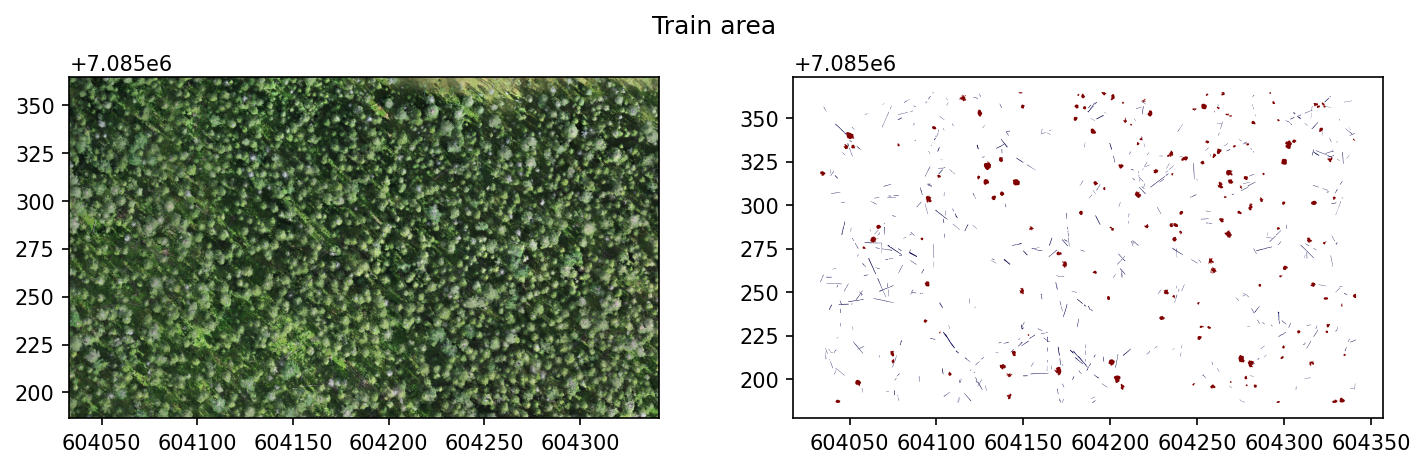

In [ ]:
fig, axs = plt.subplots(1,2, dpi=150, figsize=(10,3))
with rio.open(train_raster) as src:
    rioplot.show(src, ax=axs[0])
train_gdf = gpd.read_file(train_shp)
train_gdf.plot(column='layer', ax=axs[1], cmap='seismic')
plt.suptitle('Train area')
plt.tight_layout()
plt.show()

And test area looks like this.

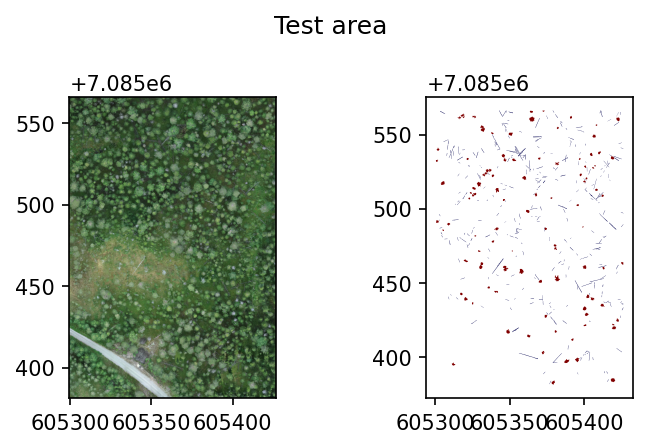

In [ ]:
fig, axs = plt.subplots(1,2, dpi=150, figsize=(5,3))
with rio.open(test_raster) as src:
    rioplot.show(src, ax=axs[0])
test_gdf = gpd.read_file(test_shp)
test_gdf.plot(column='layer', ax=axs[1], cmap='seismic')
plt.suptitle('Test area')
plt.tight_layout()
plt.show()

## Install required dependencies

In order to install `detectron2`, follow the instructions provided [here](https://detectron2.readthedocs.io/en/latest/tutorials/install.html).

## Create COCO-format dataset

In this example, the data are split into 256x256 pixel tiles with no overlap. Also set the `min_bbox_area` to 8 pixels so too small objects are discarded.

## CLI

```bash
geo2ml_create_coco_dataset \
example_data/workflow_examples/104_28_Hiidenportti_Chunk1_orto.tif \
example_data/workflow_examples/104_28_Hiidenportti_Chunk1_orto.geojson layer \
example_data/workflow_examples/coco/train example_train \
--gridsize_x 256 --gridsize_y 256 \
--ann_format polygon --min_bbox_area 8

geo2ml_create_coco_dataset \
example_data/workflow_examples/104_42_Hiidenportti_Chunk5_orto.tif \
example_data/workflow_examples/104_42_Hiidenportti_Chunk5_orto.geojson layer \
example_data/workflow_examples/coco/test example_test \
--gridsize_x 256 --gridsize_y 256 \
--ann_format polygon --min_bbox_area 8
```

## Python

In [ ]:
from geo2ml.scripts.data import create_coco_dataset

In [ ]:
outpath = path_to_data/'coco'

create_coco_dataset(raster_path=train_raster, polygon_path=train_shp, target_column='layer',
                    outpath=outpath/'train', save_grid=False, dataset_name='example_train',
                    gridsize_x=320, gridsize_y=320, ann_format='polygon', min_bbox_area=8)

create_coco_dataset(raster_path=test_raster, polygon_path=test_shp, target_column='layer',
                    outpath=outpath/'test', save_grid=False, dataset_name='example_test',
                    gridsize_x=320, gridsize_y=320, ann_format='polygon', min_bbox_area=8)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Under the hood, this command does the following:

1. Tiles the raster 

## Dataset structure

Above creates the dataset to `path_to_data/'yolo'`, so that it contains folders `train` and `test`. Both of these folders contain

* folder `images`, which contains the tiled raster patches
* folder `vectors`, which contain geojson-files corresponding to each file in `images`, if the location contains any annotations
* file `coco_polygon.json`, which is the annotation file and info for the dataset

## Train the model

In [ ]:
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, DatasetEvaluators
import os

First we need to register the datasets:

In [ ]:
register_coco_instances(name='example_train', # the name that identifies a dataset for this session
                        metadata={}, # extra metadata, can be left as an empty dict
                        json_file=outpath/'train/coco_polygon.json', # Annotation file
                        image_root=outpath/'train/images/') # directory which contains all the images
register_coco_instances('example_test', {}, outpath/'test/coco_polygon.json', outpath/'test/images')

And then modify the config file.

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("example_train",)
cfg.DATASETS.TEST = ("example_test",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.TEST.EVAL_PERIOD = 100
cfg.OUTPUT_DIR = str(outpath/'runs')
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

Next create a trainer. Here we use `DefaultTrainer` because of demo purposes.

In [ ]:
#| output: false

trainer = DefaultTrainer(cfg)

[08/08 13:07:33 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

First the trainer must `resume_or_load` the checkpoint.

In [ ]:
#| output: false

trainer.resume_or_load(resume=False)

[08/08 13:07:35 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


Then it can be trained:

In [ ]:
#| output: false

trainer.train()

[08/08 13:07:36 d2.engine.train_loop]: Starting training from iteration 0


/home/mayrajeo/miniconda3/envs/point-eo-dev/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343970094/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[08/08 13:07:53 d2.utils.events]:  eta: 0:12:42  iter: 19  total_loss: 1.161  loss_cls: 0.2418  loss_box_reg: 0.05157  loss_mask: 0.4093  loss_rpn_cls: 0.4595  loss_rpn_loc: 0.04755    time: 0.7645  last_time: 0.8001  data_time: 0.0436  last_data_time: 0.0078   lr: 0.00039962  max_mem: 3099M
[08/08 13:08:08 d2.utils.events]:  eta: 0:12:09  iter: 39  total_loss: 0.6567  loss_cls: 0.1416  loss_box_reg: 0.1011  loss_mask: 0.28  loss_rpn_cls: 0.107  loss_rpn_loc: 0.03029    time: 0.7501  last_time: 0.7123  data_time: 0.0071  last_data_time: 0.0087   lr: 0.00079922  max_mem: 3099M
[08/08 13:08:24 d2.utils.events]:  eta: 0:12:12  iter: 59  total_loss: 0.6687  loss_cls: 0.1204  loss_box_reg: 0.1115  loss_mask: 0.2179  loss_rpn_cls: 0.05842  loss_rpn_loc: 0.04113    time: 0.7659  last_time: 0.9026  data_time: 0.0067  last_data_time: 0.0067   lr: 0.0011988  max_mem: 3101M
[08/08 13:08:40 d2.utils.events]:  eta: 0:11:55  iter: 79  total_loss: 0.4619  loss_cls: 0.07288  loss_box_reg: 0.07997  los

For evaluation we need to build an evaluator to like the following:

In [ ]:
#| output: false

results = trainer.test(cfg, trainer.model, 
                       evaluators=DatasetEvaluators([COCOEvaluator('example_test', 
                                                                   output_dir=cfg.OUTPUT_DIR)]))

[08/08 13:27:06 d2.data.datasets.coco]: Loaded 158 images in COCO format from example_data/workflow_examples/coco/test/coco_polygon.json
[08/08 13:27:06 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/08 13:27:06 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/08 13:27:06 d2.data.common]: Serializing 158 elements to byte tensors and concatenating them all ...
[08/08 13:27:06 d2.data.common]: Serialized dataset takes 0.95 MiB
[08/08 13:27:06 d2.evaluation.evaluator]: Start inference on 158 batches
[08/08 13:27:08 d2.evaluation.evaluator]: Inference done 11/158. Dataloading: 0.0007 s/iter. Inference: 0.0873 s/iter. Eval: 0.0019 s/iter. Total: 0.0898 s/iter. ETA=0:00:13
[08/08 13:27:13 d2.evaluation.evaluator]: Inference done 66/158. Dataloading: 0.0011 s/iter. Inference: 0.0883 s/iter. Eval: 0.0019 s/iter. Total: 

Results are returned as `OrderedDict`:

In [ ]:
results

OrderedDict([('bbox',
              {'AP': 33.44880540699818,
               'AP50': 59.77458622455857,
               'AP75': 35.438983935163215,
               'APs': 31.02145641125612,
               'APm': 29.87210764413265,
               'APl': nan,
               'AP-groundwood': 29.446534023953113,
               'AP-uprightwood': 37.45107679004325}),
             ('segm',
              {'AP': 29.43588172775907,
               'AP50': 58.826433296379776,
               'AP75': 25.0488194053204,
               'APs': 23.09816613815339,
               'APm': 36.8700686662939,
               'APl': nan,
               'AP-groundwood': 22.00613746224115,
               'AP-uprightwood': 36.86562599327699})])

## Other libraries

[MMDetection](https://mmdetection.readthedocs.io) is another commonly used library for object detection from COCO formatted datasets. According to  [these instructions](https://mmdetection.readthedocs.io/en/dev-3.x/advanced_guides/customize_dataset.html), below should work:

```python
# the new config inherits the base configs to highlight the necessary modification
_base_ = './cascade_mask_rcnn_r50_fpn_1x_coco.py

# 1. dataset settings
dataset_type = 'CocoDataset'
classes = ('Standing', 'Fallen')
data_root = /workflow_examples/coco/'

train_dataloader = dict(
    batch_size=2,
    num_workers=2,
    dataset=dict(
        type=dataset_type,
        metainfo=dict(classes=classes),
        data_root=data_root,
        ann_file='train/coco_polygon.json',
        data_prefix=dict(img='train/images')
    )
)
...
````